Import necessary libraries

In [ ]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights, vgg16
from PIL import Image

import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

Data loader

In [ ]:
# Custom Dataset class for CIFAR-10 with lazy loading
class CIFAR10Dataset(Dataset):
    def __init__(self, data_path, batch_files, transform=None):
        self.data_path = data_path
        self.batch_files = batch_files
        self.transform = transform
        self.batch_data = None  # Only load the necessary batch when needed
        self.batch_labels = None
        self.batch_index = -1  # Track the currently loaded batch
        self.index_map = []  # Maps dataset index to batch index and in-batch index
        self._create_index_map()

    def _create_index_map(self):
        """Create a map of global indices to batch indices."""
        start_idx = 0
        for batch_num, batch_file in enumerate(self.batch_files):
            with open(os.path.join(self.data_path, batch_file), 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                batch_size = len(batch[b'labels'])
                self.index_map.extend([(batch_num, i) for i in range(batch_size)])
            start_idx += batch_size

    def _load_batch(self, batch_num):
        """Load a batch given its batch number."""
        batch_file = self.batch_files[batch_num]
        with open(os.path.join(self.data_path, batch_file), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            self.batch_data = batch[b'data'].reshape(-1, 3, 32, 32)
            self.batch_labels = batch[b'labels']
        self.batch_index = batch_num  # Update currently loaded batch

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        # Map global index to batch number and in-batch index
        batch_num, in_batch_idx = self.index_map[idx]

        # Load the batch if it's not already loaded
        if batch_num != self.batch_index:
            self._load_batch(batch_num)

        # Fetch image and label from the loaded batch
        image = self.batch_data[in_batch_idx]
        label = self.batch_labels[in_batch_idx]

        # Convert to the expected format (H x W x C)
        image = image.transpose(1, 2, 0)

        if self.transform:
            image = self.transform(image)

        return image, label


# Transformations for CIFAR-10 (ResNet expects 224x224 images)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

Training with cross validation

In [ ]:
# Custom function to train and evaluate a model with early stopping and validation accuracy
def train_and_evaluate(trainloader, validloader, model, criterion, optimizer, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # To store loss and accuracy for each epoch
    train_losses, valid_losses = [], []
    valid_accuracies = []  # To store validation accuracy
    best_valid_loss = float('inf')
    epochs_no_improve = 0  # Counter for early stopping

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train_samples = 0

        # Train on training data
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_train_samples += labels.size(0)

        # Compute epoch training loss
        epoch_train_loss = running_loss / total_train_samples
        train_losses.append(epoch_train_loss)
        print(f'Training: Loss: {epoch_train_loss:.4f}')

        # Validation loop
        model.eval()
        running_valid_loss = 0.0
        correct_predictions = 0
        total_valid_samples = 0

        with torch.no_grad():
            progress_bar = tqdm(validloader, desc=f'Epoch {epoch+1}/{num_epochs} (Valid)')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_valid_loss += loss.item() * inputs.size(0)

                # Get the predicted labels and calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_valid_samples += labels.size(0)

        # Compute epoch validation loss
        epoch_valid_loss = running_valid_loss / total_valid_samples
        valid_losses.append(epoch_valid_loss)
        print(f'Validation: Loss: {epoch_valid_loss:.4f}')

        # Compute validation accuracy
        epoch_valid_acc = correct_predictions / total_valid_samples * 100
        valid_accuracies.append(epoch_valid_acc)
        print(f'Validation: Accuracy: {epoch_valid_acc:.2f}%')

        # Check for early stopping
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Return the training and validation losses and validation accuracies
    return train_losses, valid_losses, valid_accuracies

train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
    ])

# K-Fold Cross Validation
def k_fold_cross_validation(dataset, model_class, num_folds, num_epochs, batch_size, patience):
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # To store validation performance and learning curves across folds
    all_train_losses, all_valid_losses, all_valid_accuracies, models = [], [], [], []

    # K-fold Cross Validation
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold + 1}/{num_folds}')

        # Subset the data for training and validation
        train_subset = Subset(dataset, train_idx)
        valid_subset = Subset(dataset, valid_idx)

        # Create DataLoaders for this fold - train is going to be augmented
        trainloader = DataLoader(
            [(train_transforms(image), label) for image, label in train_subset],
            batch_size=batch_size, shuffle=True, num_workers=4)
        validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        # Create a new instance of the model for each fold
        model = model_class()

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

        # Train and validate
        train_losses, valid_losses, valid_accuracies = train_and_evaluate(
            trainloader, validloader, model, criterion, optimizer, num_epochs=num_epochs, patience=patience
        )

        # Collect learning curves
        all_train_losses.append(train_losses)
        all_valid_losses.append(valid_losses)
        all_valid_accuracies.append(valid_accuracies)
        models.append(model)

    # Return learning curves for further plotting
    return all_train_losses, all_valid_losses, all_valid_accuracies, models


Load data and run training

In [ ]:
from torchvision.models import VGG16_Weights

# mounting drive
from google.colab import drive

drive.mount('/content/drive')

# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'
# Petr local path
# data_path = '/home/sejvlpet/ai_data/cifar-10-batches-py/'

# Training and test batch file names
train_batches = [f'data_batch_{i}' for i in range(1, 6)]
test_batches = ['test_batch']

# Define the necessary transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Create Dataset instance for the full training dataset
train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform)

print("resnet_models")
# Perform 5-fold cross-validation on the dataset with ResNet-50 and save the losses
#train_losses, valid_losses, _, resnet_models = k_fold_cross_validation(train_dataset, lambda: resnet50(weights=ResNet50_Weights.DEFAULT), num_folds=2, num_epochs=5, batch_size=32, patience=2)

# Save the model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_models.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(resnet_models, f)

"""print("VGG16_models")
# Perform 5-fold cross-validation on the dataset with VGG16 and save the losses
train_losses, valid_losses, _, vgg16_models = k_fold_cross_validation(train_dataset, lambda: vgg16(weights=VGG16_Weights.DEFAULT), num_folds=5, num_epochs=5, batch_size=32, patience=2)

# Save the model
vgg16_model_save_path = '/'.join(data_path.split('/')[:-3]) + "/vgg16_models.pkl"
with open(vgg16_model_save_path, 'wb') as f:
    pickle.dump(vgg16_models, f)"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
resnet_models
Fold 1/2


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
Epoch 1/5 (Train): 100%|██████████| 782/782 [02:03<00:00,  6.33it/s]


Training: Loss: 1.4029


Epoch 1/5 (Valid): 100%|██████████| 782/782 [00:42<00:00, 18.34it/s]


Validation: Loss: 0.9442
Validation: Accuracy: 67.21%


Epoch 2/5 (Train):  14%|█▎        | 106/782 [00:17<01:50,  6.09it/s]


KeyboardInterrupt: 

Without k-fold

In [ ]:
def train_and_evaluate(trainloader, validloader, model, criterion, optimizer, num_epochs=10, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # To store loss and accuracy for each epoch
    train_losses, valid_losses = [], []
    valid_accuracies = []  # To store validation accuracy
    best_valid_loss = float('inf')
    epochs_no_improve = 0  # Counter for early stopping

    # Training loop
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}")  # Debugging line
        model.train()
        running_loss = 0.0
        total_train_samples = 0

        # Train on training data
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_train_samples += labels.size(0)

        # Compute epoch training loss
        epoch_train_loss = running_loss / total_train_samples
        train_losses.append(epoch_train_loss)
        print(f'Training: Loss: {epoch_train_loss:.4f}')

        # Validation loop
        model.eval()
        running_valid_loss = 0.0
        correct_predictions = 0
        total_valid_samples = 0

        with torch.no_grad():
            progress_bar = tqdm(validloader, desc=f'Epoch {epoch+1}/{num_epochs} (Valid)')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_valid_loss += loss.item() * inputs.size(0)

                # Get the predicted labels and calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_valid_samples += labels.size(0)

        # Compute epoch validation loss
        epoch_valid_loss = running_valid_loss / total_valid_samples
        valid_losses.append(epoch_valid_loss)
        print(f'Validation: Loss: {epoch_valid_loss:.4f}')

        # Compute validation accuracy
        epoch_valid_acc = correct_predictions / total_valid_samples * 100
        valid_accuracies.append(epoch_valid_acc)
        print(f'Validation: Accuracy: {epoch_valid_acc:.2f}%')

        # Check for early stopping
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print("Returning values...")  # Debugging line
    # Return the training and validation losses and validation accuracies
    return train_losses, valid_losses, valid_accuracies

In [ ]:
# mounting drive
from google.colab import drive

drive.mount('/content/drive')

# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'

# Training and test batch file names
train_batches = [f'data_batch_{i}' for i in range(1, 6)]
test_batches = ['test_batch']

# Define the necessary transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Create Dataset instance for the full training dataset
train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform)

# Assuming CIFAR10Dataset class is defined
train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform)
valid_dataset = CIFAR10Dataset(data_path, test_batches, transform=transform)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)

# Instantiate the model (using ResNet-50)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

# Train and validate the model
train_losses, valid_losses, valid_accuracies = train_and_evaluate(
    trainloader, validloader, model, criterion, optimizer, num_epochs=5, patience=2
)

# Save the trained model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/5 (Train): 100%|██████████| 391/391 [11:51<00:00,  1.82s/it]


Training: Loss: 0.4807


Epoch 1/5 (Valid): 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Validation: Loss: 0.3148
Validation: Accuracy: 89.42%


Epoch 2/5 (Train): 100%|██████████| 391/391 [11:54<00:00,  1.83s/it]


Training: Loss: 0.2154


Epoch 2/5 (Valid): 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]


Validation: Loss: 0.3087
Validation: Accuracy: 89.28%


Epoch 3/5 (Train): 100%|██████████| 391/391 [11:49<00:00,  1.82s/it]


Training: Loss: 0.1521


Epoch 3/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.15it/s]


Validation: Loss: 0.2625
Validation: Accuracy: 91.14%


Epoch 4/5 (Train): 100%|██████████| 391/391 [11:52<00:00,  1.82s/it]


Training: Loss: 0.1094


Epoch 4/5 (Valid): 100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Validation: Loss: 0.3064
Validation: Accuracy: 90.27%


Epoch 5/5 (Train): 100%|██████████| 391/391 [11:53<00:00,  1.83s/it]


Training: Loss: 0.0931


Epoch 5/5 (Valid): 100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


Validation: Loss: 0.3024
Validation: Accuracy: 90.89%
Early stopping at epoch 5


Evaluation on test set

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from torch.utils.data import DataLoader

# Define class names based on the extracted labels
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

def test_model_with_confusion_matrix(model, testloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(testloader), total=len(testloader), desc='Testing')
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Append predictions and labels for confusion matrix and metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Identify misclassifications
            for j in range(labels.size(0)):
                if predicted[j] != labels[j]:
                    misclassified_images.append(inputs[j].cpu())
                    misclassified_labels.append(labels[j].cpu().numpy())
                    misclassified_preds.append(predicted[j].cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print the computed metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix using seaborn with class names
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return misclassified_images, misclassified_labels, misclassified_preds

Testing: 100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Confusion Matrix:
[[913   2   5   3   5   0   2   0  42  28]
 [  5 933   0   0   0   0   0   0   7  55]
 [ 16   0 869   9  46  19  25   7   7   2]
 [ 11   4  23 730  54 115  25   8   7  23]
 [  5   0   2   8 961  11   2   8   2   1]
 [  4   3  10  36  17 909   3   1   1  16]
 [  8   1  15   3  30   8 929   1   3   2]
 [  5   0   9   8  33  31   0 908   3   3]
 [ 15   2   1   0   0   0   0   1 961  20]
 [  3  15   0   1   0   0   0   0   5 976]]
Accuracy: 0.9089
Precision: 0.9121
Recall: 0.9089
F1 Score: 0.9083


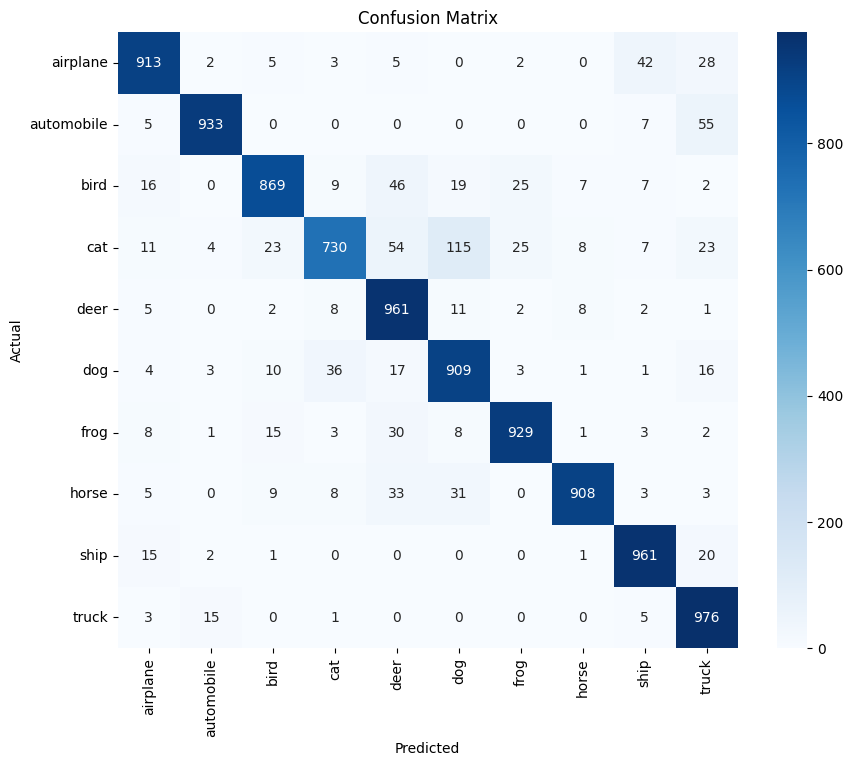

In [ ]:
# Test the model and display confusion matrix and metrics
testloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
misclassified_images, misclassified_labels, misclassified_preds = test_model_with_confusion_matrix(model, testloader)

2,3,5,7

Misclassifications

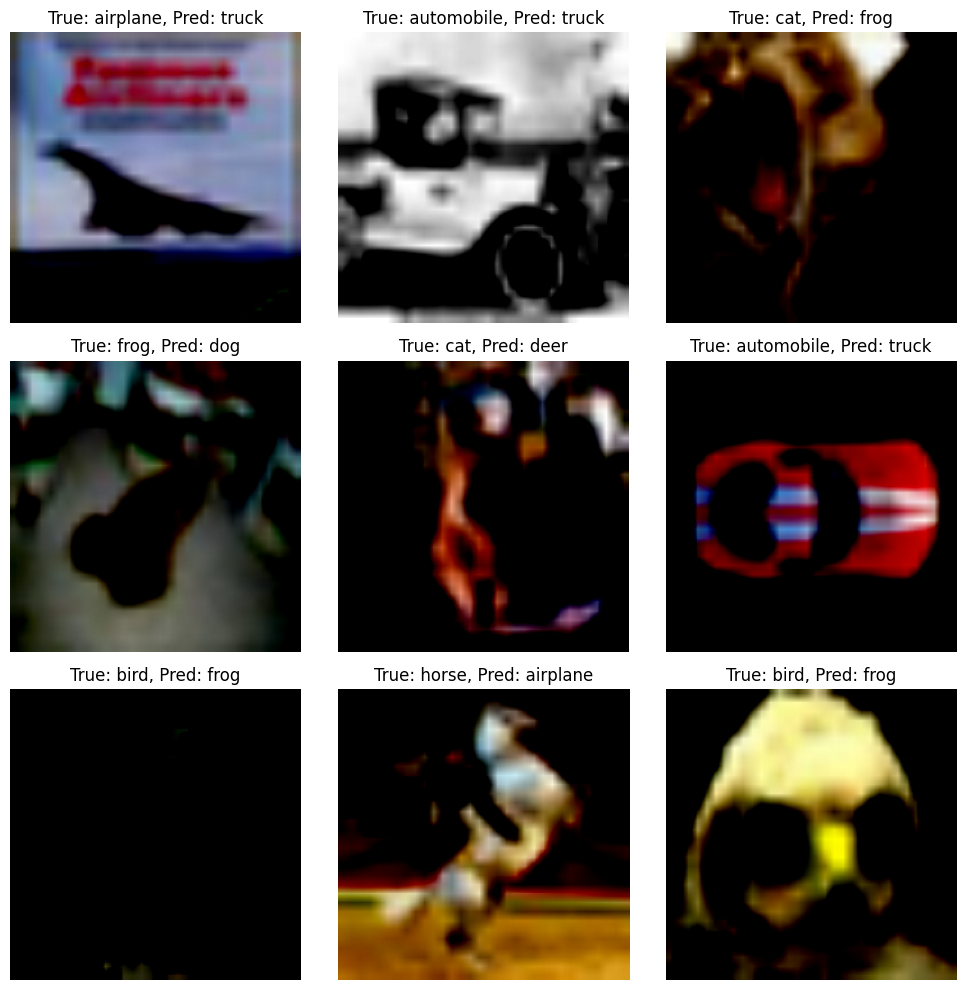

In [ ]:
def display_misclassified_images(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"True: {class_names[true_labels[i]]}, Pred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds)

Plotting learning curves

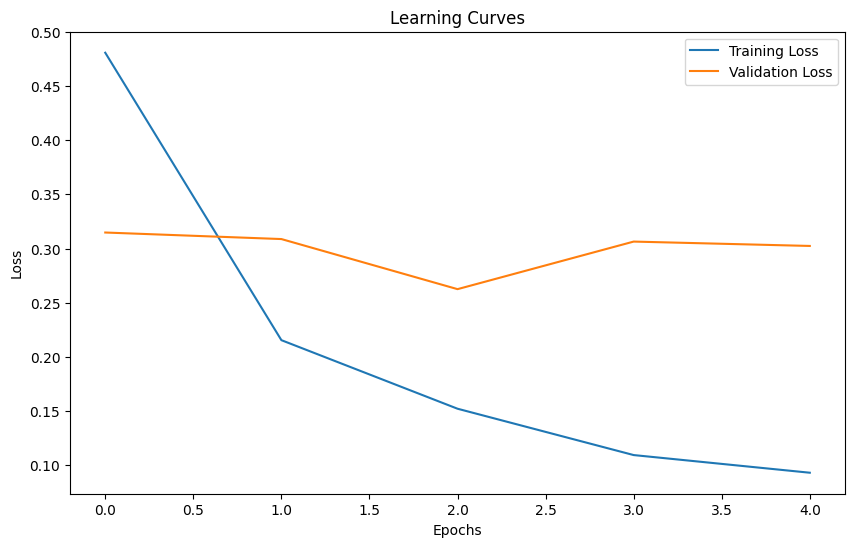

In [ ]:
def plot_learning_curves(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    #plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_learning_curves(train_losses, valid_losses)

In [ ]:
# CIFAR10Dataset class (unchanged)
class CIFAR10Dataset(Dataset):
    def __init__(self, data_path, batch_files, transform=None, default_transform=None):
        self.data_path = data_path
        self.batch_files = batch_files
        self.transform = transform  # Augmentation for specific labels
        self.default_transform = default_transform  # Default transform for all other labels
        self.batch_data = None
        self.batch_labels = None
        self.batch_index = -1
        self.index_map = []
        self._create_index_map()

    def _create_index_map(self):
        """Create a map of global indices to batch indices."""
        for batch_num, batch_file in enumerate(self.batch_files):
            with open(os.path.join(self.data_path, batch_file), 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                batch_size = len(batch[b'labels'])
                self.index_map.extend([(batch_num, i) for i in range(batch_size)])

    def _load_batch(self, batch_num):
        """Load a batch given its batch number."""
        batch_file = self.batch_files[batch_num]
        with open(os.path.join(self.data_path, batch_file), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            self.batch_data = batch[b'data'].reshape(-1, 3, 32, 32)
            self.batch_labels = batch[b'labels']
        self.batch_index = batch_num

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        batch_num, in_batch_idx = self.index_map[idx]

        # Load the batch if it's not already loaded
        if batch_num != self.batch_index:
            self._load_batch(batch_num)

        # Fetch image and label from the loaded batch
        image = self.batch_data[in_batch_idx]
        label = self.batch_labels[in_batch_idx]

        # Convert to HWC format (Height, Width, Channels)
        image = image.transpose(1, 2, 0)

        # Convert the image to a PIL image before applying transforms
        image = Image.fromarray(image)

        # Apply specific transformations for labels 2, 3, 5, and 7
        if label in [2, 3, 5, 7] and self.transform:
            image = self.transform(image)
        elif self.default_transform:
            image = self.default_transform(image)

        # At this point, all images should be resized to (224, 224)
        return image, label

In [ ]:
# mounting drive
from google.colab import drive

drive.mount('/content/drive')

# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'

# Training and test batch file names
train_batches = [f'data_batch_{i}' for i in range(1, 6)]
test_batches = ['test_batch']

# Data augmentations and transformations for CIFAR-10 (for labels 2, 3, 5, 7)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),  # Resize nach den anderen Transformationen
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Default transform for other labels (ensure resizing is included)
default_transform = transforms.Compose([
    # Andere Transformationen (falls vorhanden)
    transforms.Resize((224, 224)),  # Resize am Ende
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Instantiate datasets and dataloaders
train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform, default_transform=default_transform)
valid_dataset = CIFAR10Dataset(data_path, test_batches, transform=transform, default_transform=default_transform)

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)


# Instantiate the model (using ResNet-50)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

# Train and validate the model
train_losses, valid_losses, valid_accuracies = train_and_evaluate(
    trainloader, validloader, model, criterion, optimizer, num_epochs=5, patience=2
)

# Save the trained model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model_aug.pkl"
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting epoch 1


Epoch 1/5 (Train): 100%|██████████| 391/391 [12:40<00:00,  1.94s/it]


Training: Loss: 0.4132


Epoch 1/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Validation: Loss: 0.3099
Validation: Accuracy: 89.71%
Starting epoch 2


Epoch 2/5 (Train): 100%|██████████| 391/391 [12:05<00:00,  1.86s/it]


Training: Loss: 0.2063


Epoch 2/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Validation: Loss: 0.2457
Validation: Accuracy: 91.62%
Starting epoch 3


Epoch 3/5 (Train): 100%|██████████| 391/391 [12:06<00:00,  1.86s/it]


Training: Loss: 0.1664


Epoch 3/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Validation: Loss: 0.3269
Validation: Accuracy: 89.18%
Starting epoch 4


Epoch 4/5 (Train): 100%|██████████| 391/391 [12:02<00:00,  1.85s/it]


Training: Loss: 0.1371


Epoch 4/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Validation: Loss: 0.2341
Validation: Accuracy: 91.85%
Starting epoch 5


Epoch 5/5 (Train): 100%|██████████| 391/391 [12:09<00:00,  1.87s/it]


Training: Loss: 0.1240


Epoch 5/5 (Valid): 100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


Validation: Loss: 0.2105
Validation: Accuracy: 92.70%
Returning values...


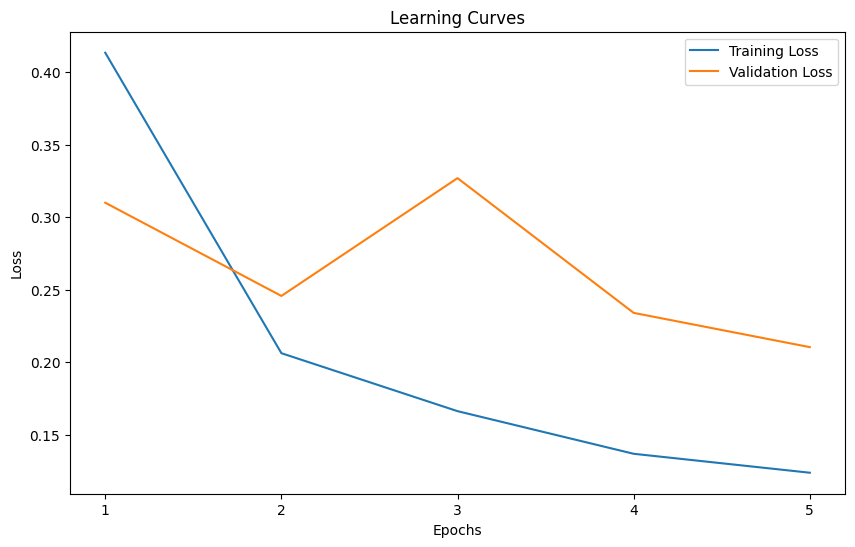

In [ ]:
def plot_learning_curves(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    #plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Learning Curves')
    plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_learning_curves(train_losses, valid_losses)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Testing: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Confusion Matrix:
[[928   2   0   1   4   1   6   0  51   7]
 [  4 920   0   1   1   0   3   0  17  54]
 [ 98   3 439   3 166   6 262   0  19   4]
 [ 30   2   0 566 162  32 163   1  29  15]
 [  7   0   1   1 959   0  23   1   8   0]
 [ 11   1   0  19 137 670 153   1   2   6]
 [  2   0   0   1   9   0 987   0   1   0]
 [ 29   0   0   1 224   9  30 700   2   5]
 [ 21   2   1   0   0   0   2   0 971   3]
 [  3  23   0   0   0   0   2   0  23 949]]
Accuracy: 0.8089
Precision: 0.8620
Recall: 0.8089
F1 Score: 0.8049


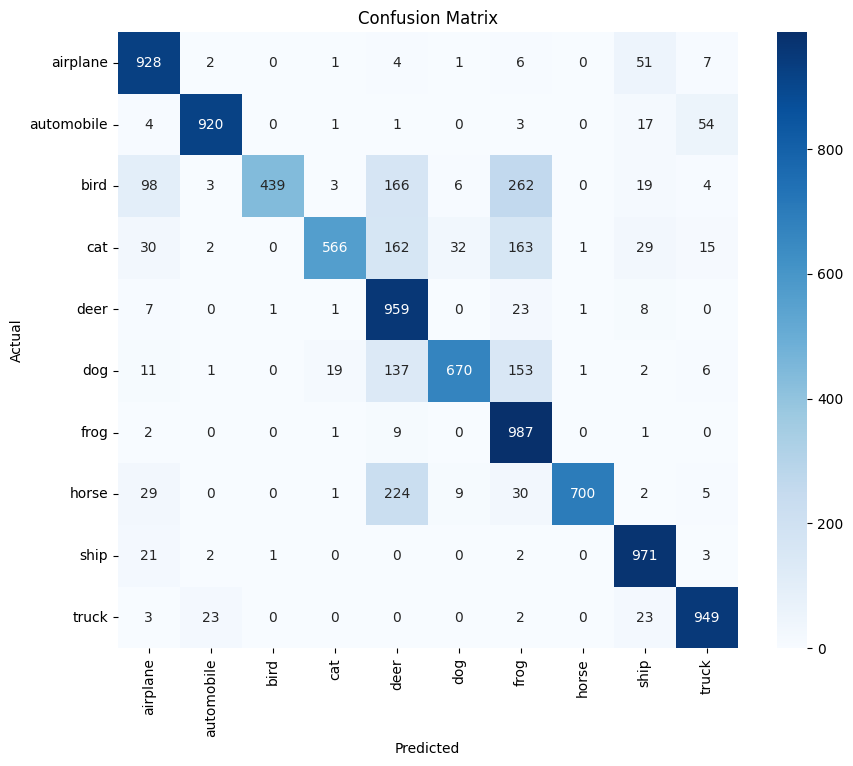

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'
test_batches = ['test_batch']

# Default transform for other labels (ensure resizing is included)
default_transform = transforms.Compose([
    # Andere Transformationen (falls vorhanden)
    transforms.Resize((224, 224)),  # Resize am Ende
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Instantiate the test dataset
test_dataset = CIFAR10Dataset(data_path, test_batches, default_transform=default_transform)

# Test the model and display confusion matrix and metrics
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load our trained model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model_aug.pkl"
with open(model_save_path, 'rb') as f:
    model = pickle.load(f)
model.to(device)

misclassified_images, misclassified_labels, misclassified_preds = test_model_with_confusion_matrix(model, testloader)